TP2: Visión por computadora I (22Co2025)

Integrantes:

    Barniquez Piñero, Alexis Geraldine
    Paniagua, Daniel Gerardo
    Salamone Castro, Brian Adriano


# Enunciado

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en  
`Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

# Preparación

## Función de clonado de repositorio

In [296]:
import os

def clone_repository(owner, repository):
    print(f"Cloning {repository}...")
    !git clone https://github.com/{owner}/{repository}.git
    os.chdir(repository)

def pull_repository(repository):
    print(f"Pulling latest changes from {repository}...")
    os.chdir(repository)
    !git pull

os.chdir("/content")

REPO_OWNER = "alexisbarnique"
REPO_NAME = "vision-por-computadora-22Co2025-tps"
TP3_DIR = f"/content/{REPO_NAME}/TP3"
TEMPLATE_PATH = f"{TP3_DIR}/template/pattern.png"
IMG_DIR = f"{TP3_DIR}/images"

if not os.path.exists(REPO_NAME):
    clone_repository(REPO_OWNER, REPO_NAME)
else:
    pull_repository(REPO_NAME)

Pulling latest changes from vision-por-computadora-22Co2025-tps...
Already up to date.


## Carga de la imagen template

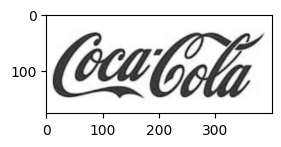

In [323]:
import matplotlib.pyplot as plt
import cv2 as cv

template = cv.imread(TEMPLATE_PATH,0)


w, h = template.shape[::-1]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(template, cmap='gray')

## Función de carga de las imagenes a procesar

In [298]:
def cargar_imagenes_desde_carpeta(folder):
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            yield img, filename

# Resolución punto 1

In [ ]:
!pip install supervision
import supervision as sv

In [ ]:
# Inicializamos el detector ORB
orb = cv.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(template,None)
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

for img, filename in cargar_imagenes_desde_carpeta(IMG_DIR):
  kp2, des2 = orb.detectAndCompute(img,None)

  # Coincidimos descriptores.
  matches = bf.match(des1, des2)

  # Los ordenamos según distancia
  matches = sorted(matches, key = lambda x:x.distance)

  # Dibujamos las primeras 30 coincidencias
  n=30
  img3 = cv.drawMatches(template,kp1,img,kp2,matches[:n],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  sv.plot_image(img3)

No se encontraron suficientes coincidencias - 7/8


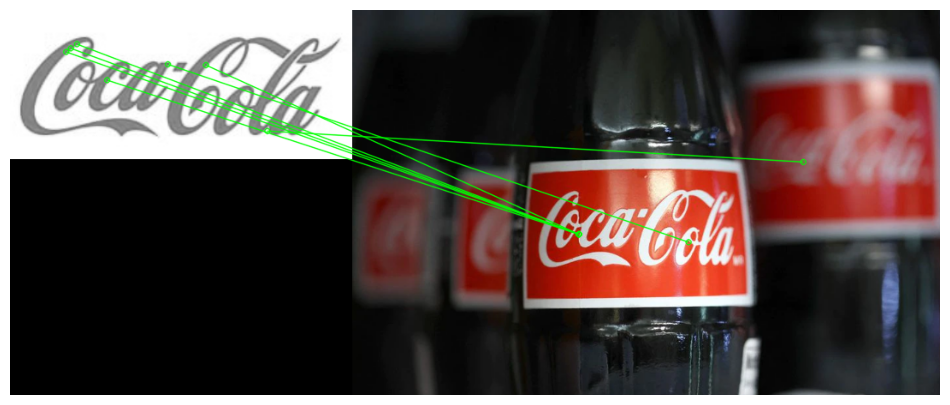

No se encontraron suficientes coincidencias - 1/8


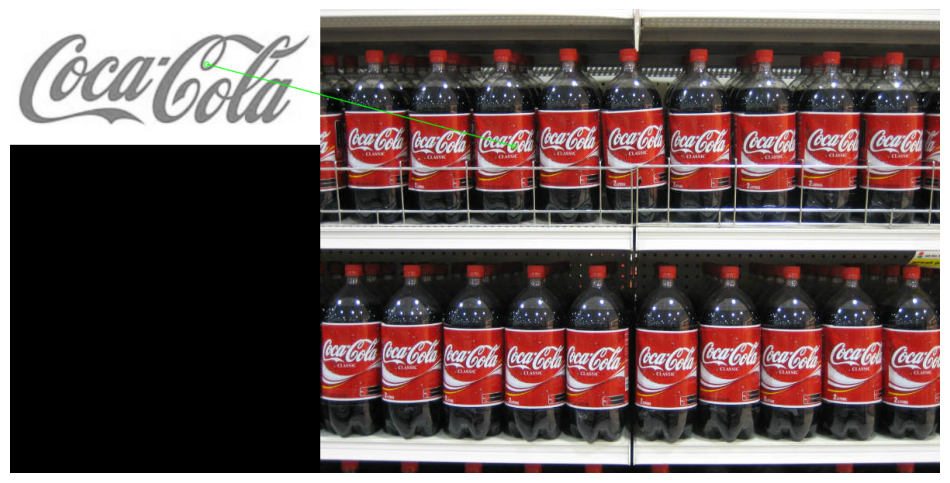

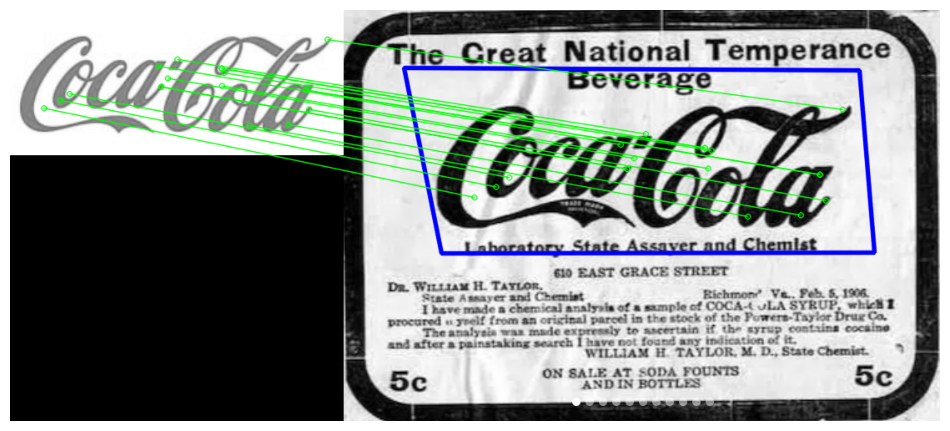

No se encontraron suficientes coincidencias - 1/8


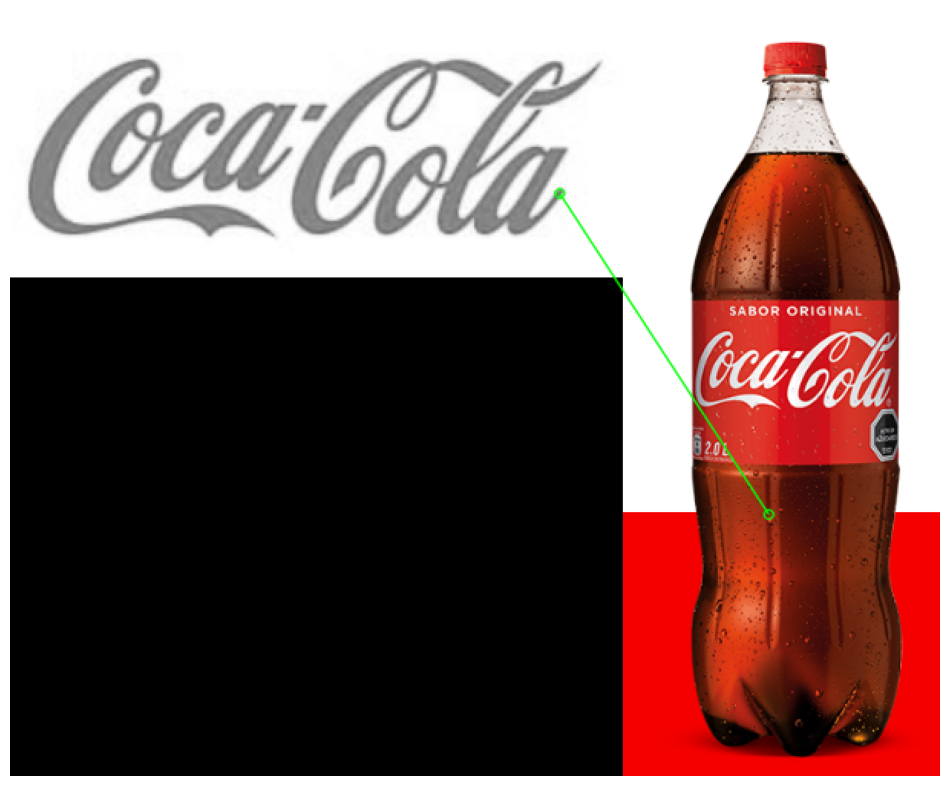

No se encontraron suficientes coincidencias - 3/8


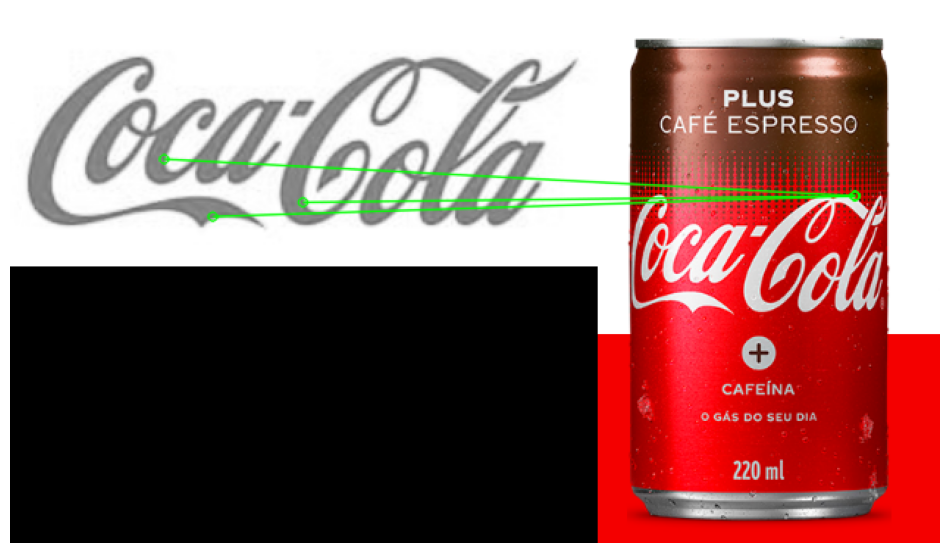

No se encontraron suficientes coincidencias - 1/8


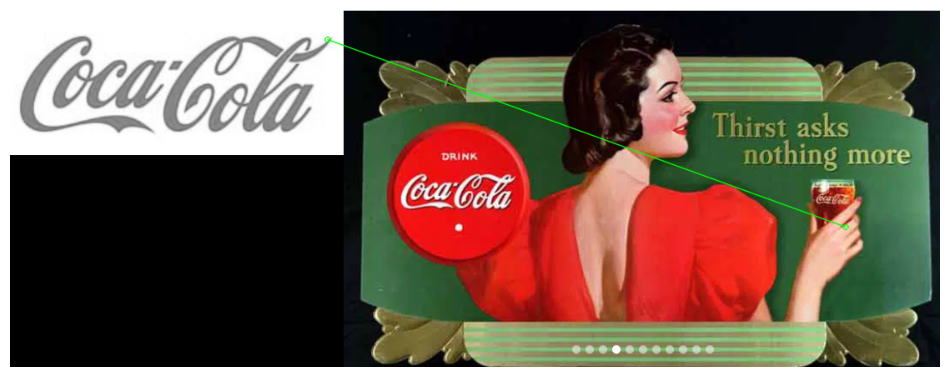

No se encontraron suficientes coincidencias - 5/8


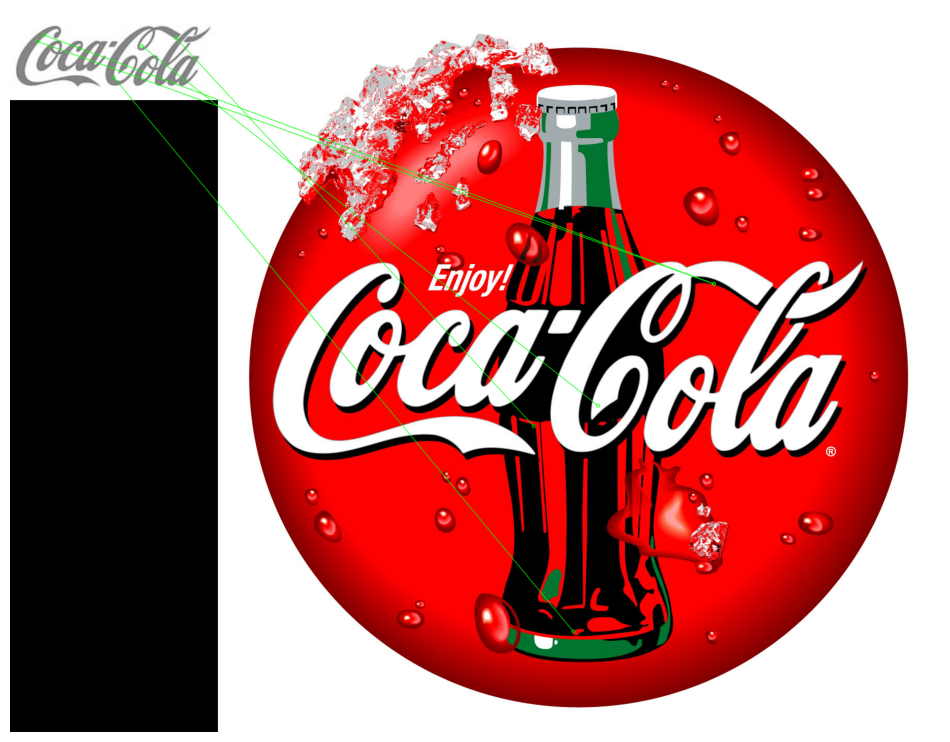

In [314]:
# Inicializamos el detector SIFT + FLANN + HOMOGRAFIA
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(template,None)
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

for img, filename in cargar_imagenes_desde_carpeta(IMG_DIR):
  kp2, des2 = sift.detectAndCompute(img,None)
  # BFMatcher con parámetros por defecto

  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks = 50)
  flann = cv.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des1,des2,k=2)

  # Guardar todos las buenas coincidencias según la verificación de Ratio de Lowe
  good = []
  for m,n in matches:
      if m.distance < 0.7*n.distance:
          good.append(m)


  MIN_MATCH_COUNT = 8

  if len(good) > MIN_MATCH_COUNT:
      src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
      M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
      matchesMask = mask.ravel().tolist()
      h,w = template.shape
      pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
      dst = cv.perspectiveTransform(pts, M)
      img = cv.polylines(img, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
  else:
      print( "No se encontraron suficientes coincidencias - {}/{}".format(len(good), MIN_MATCH_COUNT) )
      matchesMask = None


  draw_params = dict(matchColor = (0,255,0), # dibujar coincidencias en verde
                   singlePointColor = None,
                   matchesMask = matchesMask, # dibujar solo inliers
                   flags = 2)
  img3 = cv.drawMatches(template, kp1, img, kp2, good, None, **draw_params)
  sv.plot_image(img3)

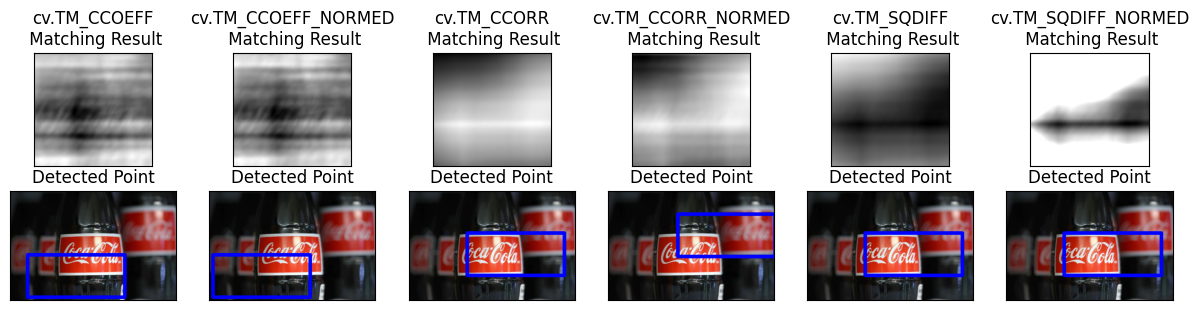

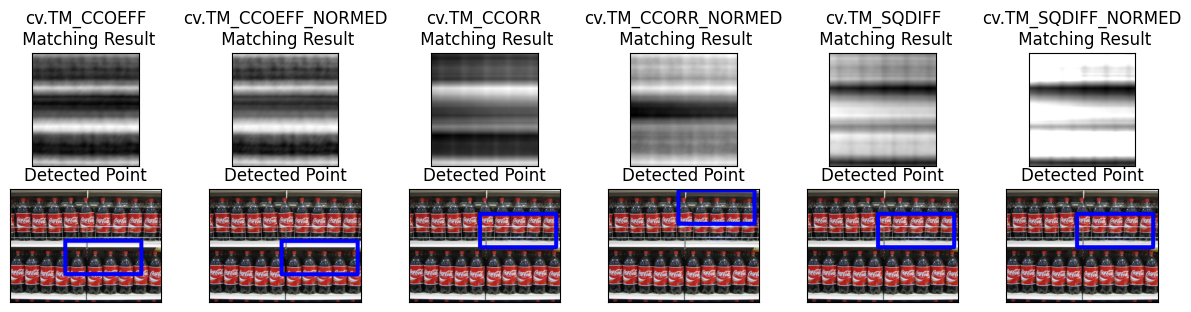

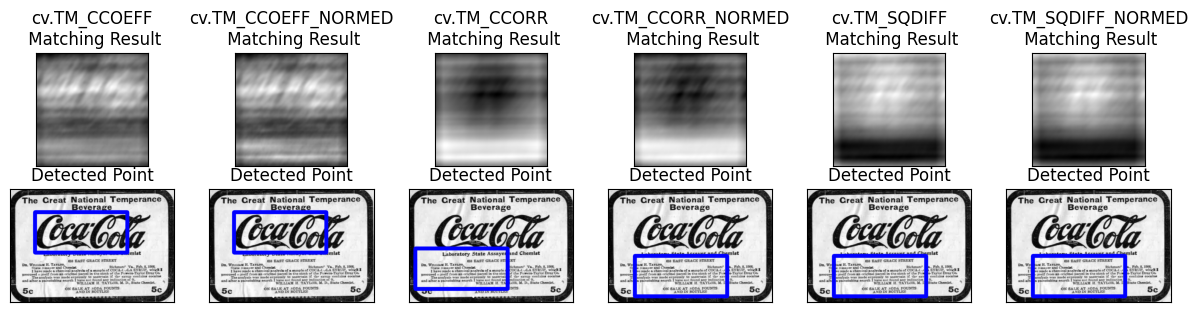

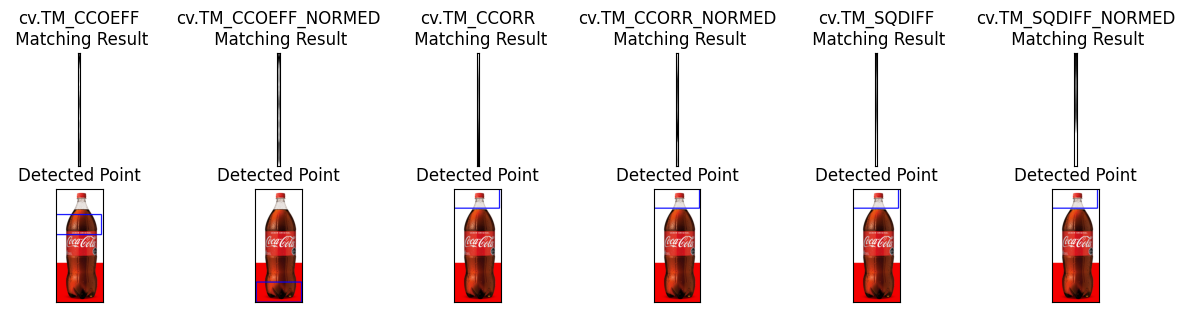

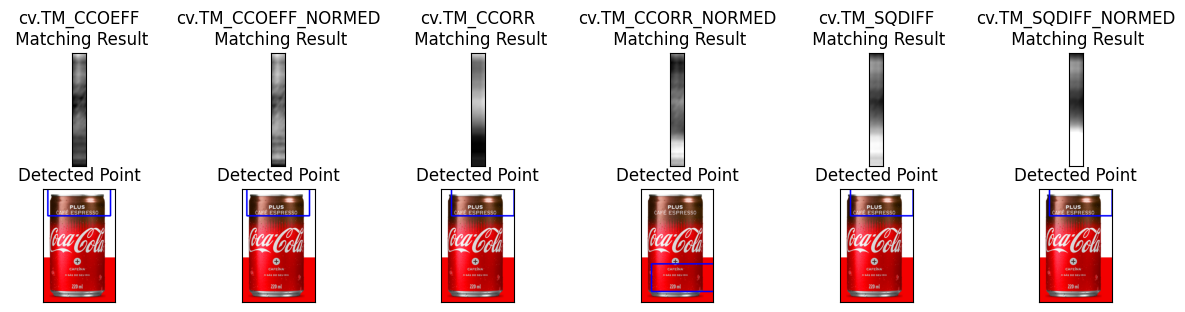

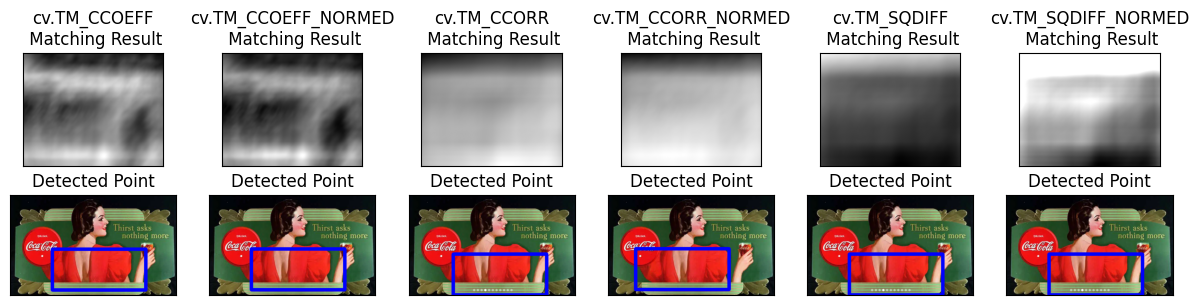

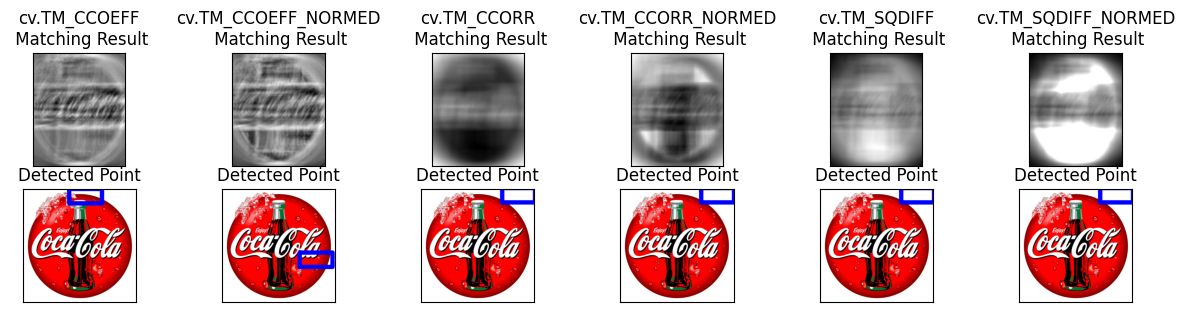

In [324]:
# Los 6 métodos posibles para comparación:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

for img, filename in cargar_imagenes_desde_carpeta(IMG_DIR):
  *_, img_w, img_h = img.shape[::-1]

  aux_t = template

  w, h = aux_t.shape[::-1]

  while img_w <= w or img_h <= h:
    # TODO Arreglar estos casos. Usando pirámides?
    # print(f'Imagen saltada: {filename} -- template no entra completo en ella.')
    aux_t = cv.pyrDown(aux_t)
    w, h = aux_t.shape[::-1]

  img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
  img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  plt.figure(figsize=(15, 5))

  for index, meth in enumerate(methods):
    # Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    img_salida = img_rgb.copy()

    method = eval(meth)

    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    res = cv.matchTemplate(img_gray, aux_t, method)

    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc

    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    bottom_right = (top_left[0] + w, top_left[1] + h)
    rect_width = int(img_w* img_h ** .5)//1000
    cv.rectangle(img_salida, top_left, bottom_right, (0,0, 255), rect_width)

    # Graficamos el procesamiento y la salida
    #----------------------------------------


    # Resultado de coincidencia
    # plt.suptitle(meth)

    plt.subplot(3,len(methods),len(methods)+index+1)
    plt.imshow(res,cmap = 'gray')
    plt.title(meth+'\n Matching Result'), plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(3,len(methods),len(methods)*2+index+1)
    plt.imshow(img_salida)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

  plt.show()
  print()
  print()


# Resolución punto 2

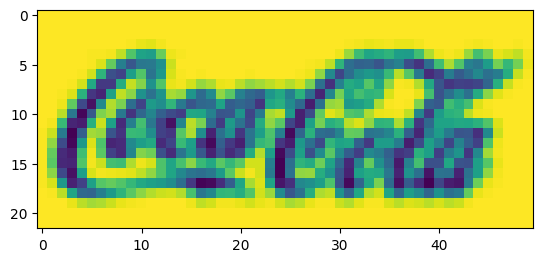

In [187]:

# img = cv.imread(os.path.join(IMG_DIR,'coca_multi.png'))
base = template.copy()

# Creamos la pirámide Gaussiana
piramide_gauss = [base]
for i in range(3):
    base = cv.pyrDown(base)
    piramide_gauss.append(base)

# El último nivel de la Gaussiana permanece en el mismo lugar en la Laplaciana
punta_laplaciana = piramide_gauss[-1]

# Creamos la pirámide Laplaciana
piramide_laplace = [punta_laplaciana]
for i in range(3,0,-1):
    size = (piramide_gauss[i - 1].shape[1], piramide_gauss[i - 1].shape[0])
    gaussiana_expandida = cv.pyrUp(piramide_gauss[i], dstsize=size)
    laplaciana = cv.subtract(piramide_gauss[i-1], gaussiana_expandida)
    piramide_laplace.append(laplaciana)
    plt.imshow(laplaciana)

plt.imshow(punta_laplaciana)

0.62283087 0.9875988
Nueva resolución (44, 100)
0.67297536 0.96131796


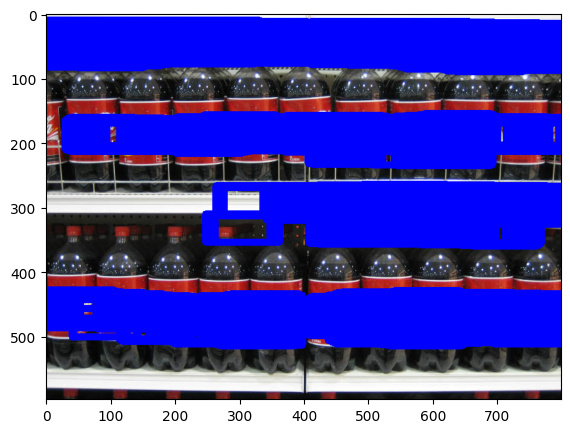

In [295]:
import numpy as np


img = cv.imread(os.path.join(IMG_DIR,'coca_multi.png'))
template = base

*_, img_w, img_h = img.shape[::-1]

plt.figure(figsize=(15, 5))
for i in range(3):

  w, h = template.shape[::-1]
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  res = cv.matchTemplate(img_gray, template, cv.TM_CCORR_NORMED)
  res2 = cv.matchTemplate(img_gray, template, cv.TM_SQDIFF_NORMED)

  threshold = 0.90

  print(np.min(res), np.max(res))
  loc = np.where((res >= threshold)&(res2> .7))
  if len(loc[0]) == 0 or i<1:
    # print(img.shape)
    # print([e.shape for e in piramide_laplace])
    lap = piramide_laplace[i+1]
    *_, lap_w, lap_h = lap.shape[::-1]
    template = cv.pyrUp(template, dstsize=(lap_w, lap_h)) + lap
    print(f'Nueva resolución {template.shape}')
    continue

  for top_left in zip(*loc[::-1]):
    bottom_right = (top_left[0] + w, top_left[1] + h)
    rect_width = int(img_w* img_h ** .5) // 2000
    cv.rectangle(img_rgb, top_left, bottom_right, (0, 0, 255), rect_width)

  plt.imshow(img_rgb)
  break
  #cv.imwrite('res.png',img_rgb)

# Resolución punto 3

In [ ]:
import numpy as np

for img, filename in cargar_imagenes_desde_carpeta(IMG_DIR):
  *_, img_w, img_h = img.shape[::-1]

  if img_w <= w or img_h <= h:
    # TODO Arreglar estos casos. Usando pirámides?
    print(f'Imagen saltada: {filename} -- template no entra completo en ella.')
    continue

  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  plt.figure(figsize=(15, 5))

  res = cv.matchTemplate(img_gray, template, cv.TM_CCOEFF_NORMED)

  threshold = 0.75

  loc = np.where( res >= threshold)
  for top_left in zip(*loc[::-1]):
    bottom_right = (top_left[0] + w, top_left[1] + h)
    rect_width = int(img_w* img_h ** .5) // 1000
    cv.rectangle(img_rgb, top_left, bottom_right, (0, 0, 255), rect_width)

  plt.imshow(img_rgb)
  #cv.imwrite('res.png',img_rgb)